In [ ]:
# --- BƯỚC 1: CÀI ĐẶT MÔI TRƯỜNG & LOAD MODEL (ĐÃ SỬA) ---
import os
import sys
from google.colab import drive

# 1. Kết nối Drive
if not os.path.exists('/content/drive'):
    print("🔗 Đang kết nối Google Drive...")
    drive.mount('/content/drive')

# 2. Cài thư viện (QUAN TRỌNG: Đã thêm ultralytics)
print("⏳ Đang cài đặt thư viện đầy đủ (sẽ mất khoảng 30s)...")
try:
    import ultralytics
except ImportError:
    !pip install ultralytics
    !pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt
    !pip install opencv-python-headless

import torch
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# 3. Load Model vào bộ nhớ
# ======================================================
# 👉 SỬA ĐƯỜNG DẪN FILE MODEL CỦA BẠN Ở DÒNG DƯỚI:
# (Bạn kiểm tra xem file best.pt của bạn ở exp mấy nhé, ví dụ exp2 hoặc exp8)
MY_MODEL_PATH = '/content/drive/MyDrive/yolov5/runs/train/exp2/weights/best.pt'
# ======================================================

print(f"⏳ Đang nạp model từ: {MY_MODEL_PATH} ...")
try:
    if not os.path.exists(MY_MODEL_PATH):
        print(f"❌ LỖI: Không tìm thấy file tại {MY_MODEL_PATH}")
        print("👉 Hãy vào Drive kiểm tra xem file best.pt nằm ở folder exp mấy?")
    else:
        # Load model custom
        # force_reload=True để máy tải lại code mới nhất, tránh lỗi cũ
        model = torch.hub.load('ultralytics/yolov5', 'custom', path=MY_MODEL_PATH, verbose=False, force_reload=True)
        model.conf = 0.45
        print("✅ ĐÃ SẴN SÀNG! Bạn hãy chuyển sang Bước 2 để chạy thử.")
except Exception as e:
    print(f"❌ Vẫn bị lỗi nạp model: {e}")
    print("👉 Lời khuyên: Hãy thử Restart Runtime (Menu Runtime -> Restart Session) rồi chạy lại ô này.")

🔗 Đang kết nối Google Drive...
Mounted at /content/drive
⏳ Đang cài đặt thư viện đầy đủ (sẽ mất khoảng 30s)...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.1 MB/s eta 0:00:00
⏳ Đang nạp model từ: /content/drive/MyDrive/yolov5/runs/train/exp2/weights/best.pt ...


/usr/local/lib/python3.12/dist-packages/torch/hub.py:335: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-12-18 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


✅ ĐÃ SẴN SÀNG! Bạn hãy chuyển sang Bước 2 để chạy thử.


📸 Đang xử lý ẢNH...
✅ Xong! Ảnh lưu tại: /content/ket_qua.jpg


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


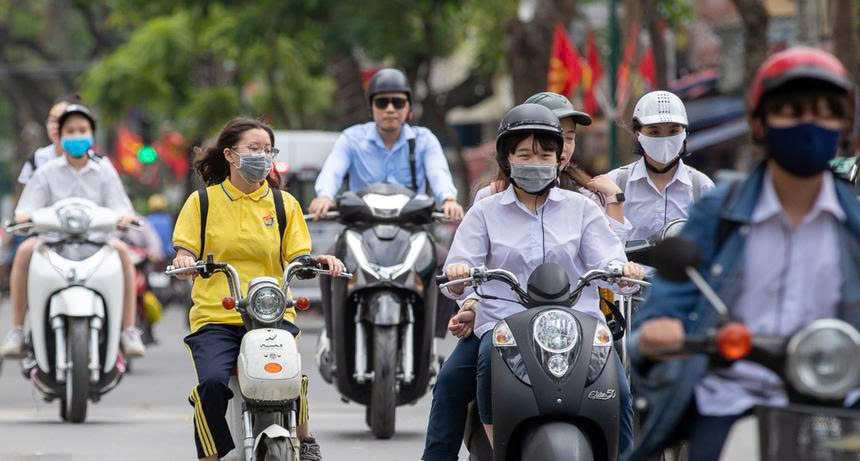

In [ ]:
# --- BƯỚC 2: XỬ LÝ ẢNH HOẶC VIDEO ---
from IPython.display import clear_output

# ================= CẤU HÌNH INPUT =================
# 👉 Dán đường dẫn file Ảnh hoặc Video cần test vào đây:
INPUT_PATH = '/content/xeco.mp4'

# Tên file kết quả (Tùy chọn)
OUTPUT_NAME = '/content/ket_qua'
# ==================================================

def run_detection():
    # Kiểm tra xem Model đã được nạp ở Bước 1 chưa
    if 'model' not in globals():
        print("❌ LỖI: Bạn chưa chạy Bước 1. Hãy chạy ô code bên trên trước!")
        return

    if not os.path.exists(INPUT_PATH):
        print(f"❌ LỖI: Không tìm thấy file input '{INPUT_PATH}'")
        return

    # Hàm vẽ khung (Đơn giản: Xanh/Đỏ)
    def draw_predictions(img, results):
        detections = results.xyxy[0].cpu().numpy()
        for det in detections:
            x1, y1, x2, y2, conf, cls = det
            label = model.names[int(cls)]

            # Logic tô màu
            if label == 'Without helmet':
                color = (0, 0, 255) # ĐỎ
                txt = f"KHONG MU ({conf:.2f})"
            elif label == 'With helmet':
                color = (0, 255, 0) # XANH LÁ
                txt = "CO MU"
            else:
                color = (255, 100, 0) # MÀU CAM (Lớp khác)
                txt = label

            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            cv2.putText(img, txt, (int(x1), int(y1)-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        return img

    file_ext = os.path.splitext(INPUT_PATH)[1].lower()

    # === XỬ LÝ ẢNH ===
    if file_ext in ['.jpg', '.jpeg', '.png', '.bmp']:
        print("📸 Đang xử lý ẢNH...")
        frame = cv2.imread(INPUT_PATH)
        results = model(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        result_img = draw_predictions(frame, results)

        save_path = OUTPUT_NAME + ".jpg"
        cv2.imwrite(save_path, result_img)
        print(f"✅ Xong! Ảnh lưu tại: {save_path}")
        cv2_imshow(result_img)

    # === XỬ LÝ VIDEO ===
    elif file_ext in ['.mp4', '.avi', '.mov']:
        print("🎥 Đang xử lý VIDEO...")
        cap = cv2.VideoCapture(INPUT_PATH)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)

        save_path = OUTPUT_NAME + ".mp4"
        out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

        cnt = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break
            cnt += 1
            if cnt % 20 == 0: print(f"-> Đang chạy frame {cnt}...")

            results = model(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            processed_frame = draw_predictions(frame, results)
            out.write(processed_frame)

        cap.release(); out.release()
        clear_output()
        print(f"✅ XONG! Video lưu tại: {save_path}")
        print("👉 Hãy tải về máy để xem.")

    else:
        print("❌ File không hỗ trợ (chỉ dùng ảnh hoặc video mp4/avi).")

# Chạy lệnh
run_detection()